<div class="alert alert-block alert-info">
    <h1>Análisis de Series Temporales</h1>
    <h3>Clase 5</h3>
    <h3>Ejercicio 1</h3>
        <p>Docente: Rodrigo Del Rosso<p>
        <p><p>Asistentes: Sebastián Calcagno y Braian Drago <p> <p>
</div>

**Modelos Ensambles**   

Los modelos de Gradient Boosting, como XGBoost y LightGBM, han demostrado su eficacia en una amplia gama de aplicaciones de aprendizaje automático, desde clasificación hasta regresión. Sin embargo, una de las áreas más desafiantes y emocionantes en las que estos algoritmos han encontrado aplicabilidad es en la predicción de series de tiempo. La adaptación de estos modelos al dominio de series temporales es esencial, ya que las características únicas de este tipo de datos, como la dependencia temporal y la estacionalidad, requieren un enfoque especializado. En esta introducción, exploraremos cómo se aplican y adaptan los modelos de aumento de gradiente para abordar problemas de predicción de series de tiempo.

¿Qué es el Boosting? Boosting es una técnica conjunta de aprendizaje automático que combina múltiples modelos débiles (weak models) en un único modelo fuerte. En Boosting, cada modelo aprende de los errores del modelo anterior, lo que da como resultado un modelo mejor en general. El objetivo es mejorar la precisión de un modelo reduciendo la varianza y el sesgo en los datos. Boosting es una técnica popular para resolver problemas de clasificación y regresión.

Las principales diferencias de LightGBM frente a XGBoost es su estrategia de crecimiento de árboles en forma de hojas, su técnica exclusiva de agrupación de funciones y su menor consumo de memoria.

Queremos predecir el consumo futuro.  

Documentación: https://xgboost.readthedocs.io/en/stable/python/python_intro.html

Carga de Librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb   #
import lightgbm as lgb #
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import plot_importance, plot_tree
color_pal = sns.color_palette()
plt.style.use('tableau-colorblind10')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Carga y Procesamiento inicial del dataset

Es un dataset de uso en Kaggle - que a su vez proviene del sitio web de PJM (https://www.pjm.com/)

In [ ]:
URL='https://raw.githubusercontent.com/sebcalcagno/AnalisisSeriesTemporales/main/consumo_2.csv'
df = pd.read_csv(URL)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [ ]:
df['Datetime'].dtype

dtype('O')

In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y-%m-%d %H:%M:%S')


In [ ]:
df = df.set_index('Datetime') # Ponemos a 'Datetime' como el índice del DataFrame
df.sort_index(inplace=True) # orden cronologico
print(df.shape)
df.head()

(145366, 1)


PJME_MW
Datetime                    
2002-01-01 01:00:00  30393.0
2002-01-01 02:00:00  29265.0
2002-01-01 03:00:00  28357.0
2002-01-01 04:00:00  27899.0
2002-01-01 05:00:00  28057.0

In [ ]:
pd.to_datetime(df.index)

DatetimeIndex(['2002-01-01 01:00:00', '2002-01-01 02:00:00',
               '2002-01-01 03:00:00', '2002-01-01 04:00:00',
               '2002-01-01 05:00:00', '2002-01-01 06:00:00',
               '2002-01-01 07:00:00', '2002-01-01 08:00:00',
               '2002-01-01 09:00:00', '2002-01-01 10:00:00',
               ...
               '2018-08-02 15:00:00', '2018-08-02 16:00:00',
               '2018-08-02 17:00:00', '2018-08-02 18:00:00',
               '2018-08-02 19:00:00', '2018-08-02 20:00:00',
               '2018-08-02 21:00:00', '2018-08-02 22:00:00',
               '2018-08-02 23:00:00', '2018-08-03 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

In [ ]:
df.tail()

PJME_MW
Datetime                    
2018-08-02 20:00:00  44057.0
2018-08-02 21:00:00  43256.0
2018-08-02 22:00:00  41552.0
2018-08-02 23:00:00  38500.0
2018-08-03 00:00:00  35486.0

Los datos tienen una frecuencia de registro cada 1 hora

**Visualizamos la serie:**

In [ ]:
sns.color_palette()

[(0.0, 0.4196078431372549, 0.6431372549019608),
 (1.0, 0.5019607843137255, 0.054901960784313725),
 (0.6705882352941176, 0.6705882352941176, 0.6705882352941176),
 (0.34901960784313724, 0.34901960784313724, 0.34901960784313724),
 (0.37254901960784315, 0.6196078431372549, 0.8196078431372549),
 (0.7843137254901961, 0.3215686274509804, 0.0),
 (0.5372549019607843, 0.5372549019607843, 0.5372549019607843),
 (0.6352941176470588, 0.7843137254901961, 0.9254901960784314),
 (1.0, 0.7372549019607844, 0.4745098039215686),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529)]

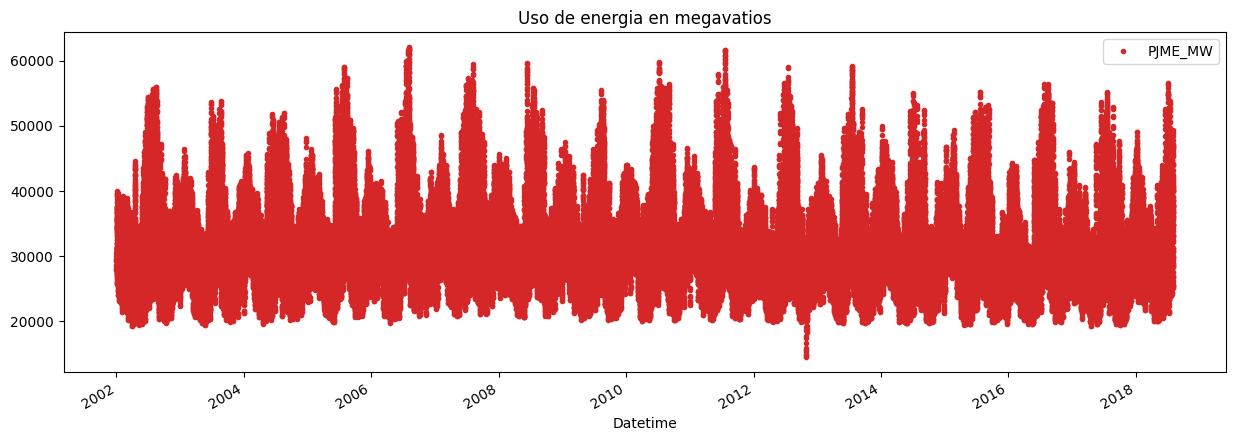

In [ ]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[3],
        title='Uso de energia en megavatios')
plt.show()

Que observamos en la gráfica?

Presencia de outliers ? <br/>
Valores faltante ?

Valores faltantes

In [ ]:
print('Cantidad de NaNs:')
for column in df:
    nans = df[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs:
	Columna PJME_MW: 0


Separamos train y test

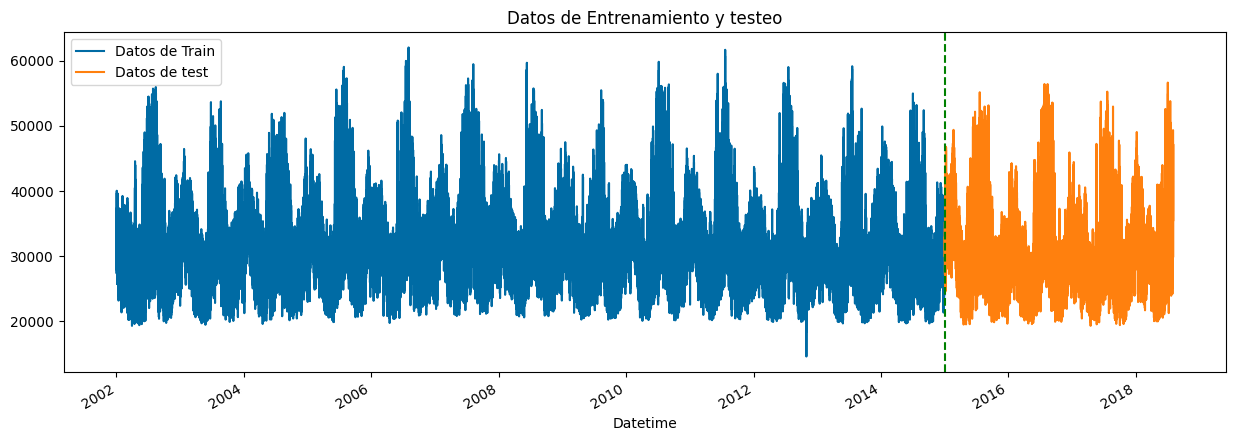

In [ ]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Datos de Train', title='Datos de Entrenamiento y testeo')
test.plot(ax=ax, label='Datos de test')
ax.axvline('01-01-2015', color='green', ls='--')
ax.legend(['Datos de Train', 'Datos de test'])
plt.show()

**Feature Engineering**

https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.dayofweek.html

In [ ]:
def create_features(df):
    """
    Creamos features basadas en el índice tiempo.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [ ]:
df = create_features(df)
train = create_features(train)
test = create_features(test)

In [ ]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'PJME_MW'

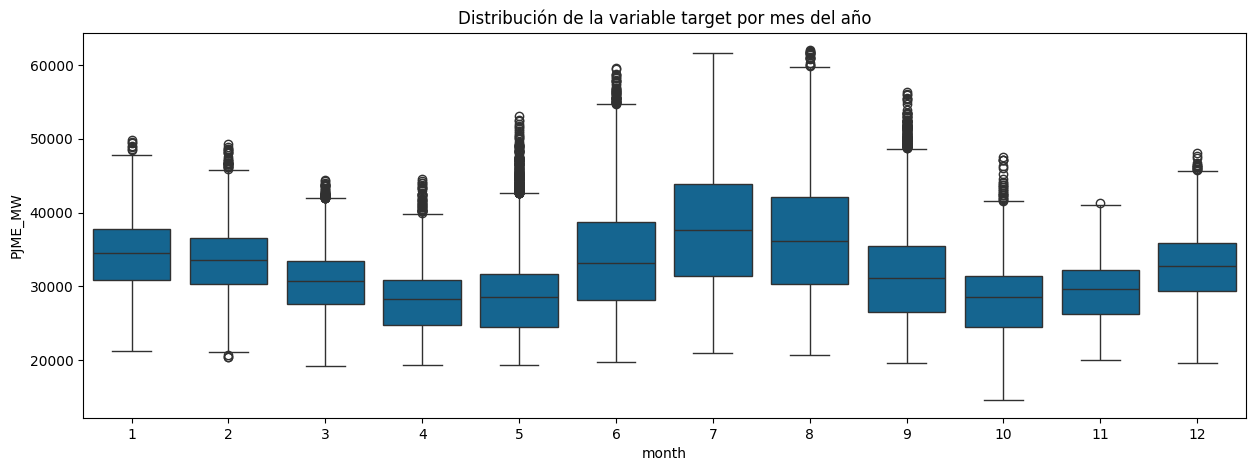

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x = 'month' , y = 'PJME_MW')
ax.set_title('Distribución de la variable target por mes del año')
plt.show()

Entrenamiento

n_estimators = cuantos arboles crea el modelo

early_stopping_rounds= si el modelo no mejora el entrenamiento para.

eval_set=[(X_train, y_train), (X_test, y_test)]: Asi evalua en el entrenamiento, asi nutre el early stoppig rounds.

In [ ]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# XGBoost (Extreme Gradient Boosting)

In [ ]:
regXGB = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
regXGB.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:5179.23300	validation_1-rmse:5359.30943
[61]	validation_0-rmse:2015.77042	validation_1-rmse:4145.45887


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

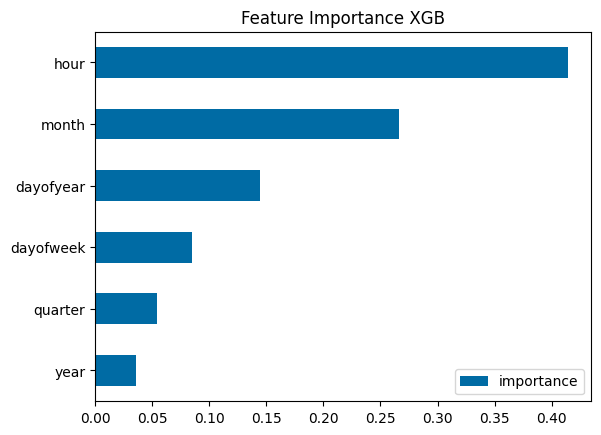

In [ ]:
fi = pd.DataFrame(data=regXGB.feature_importances_,
             index=regXGB.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance XGB')
plt.show()

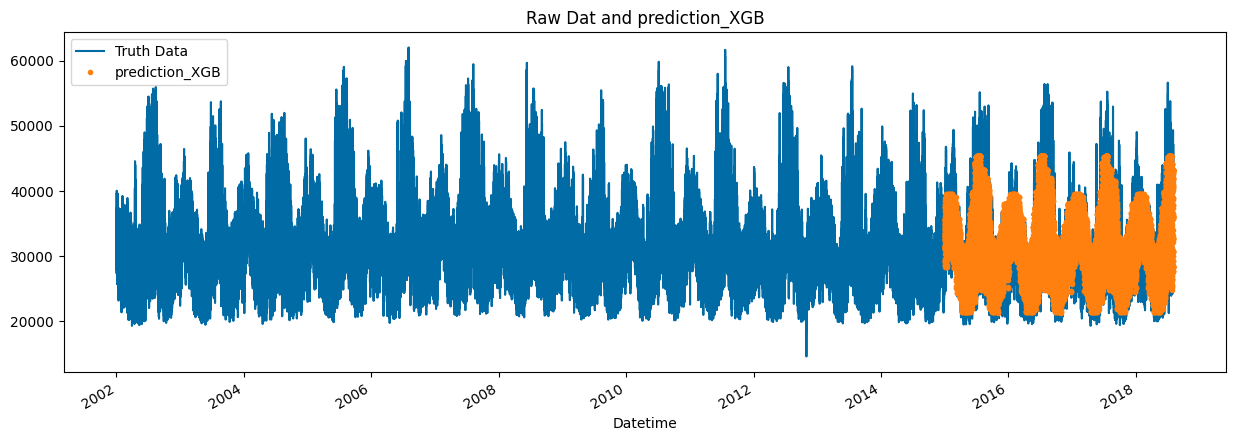

In [ ]:
test['prediction_XGB'] = regXGB.predict(X_test)
df = df.merge(test[['prediction_XGB']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction_XGB'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'prediction_XGB'])
ax.set_title('Raw Dat and prediction_XGB')
plt.show()

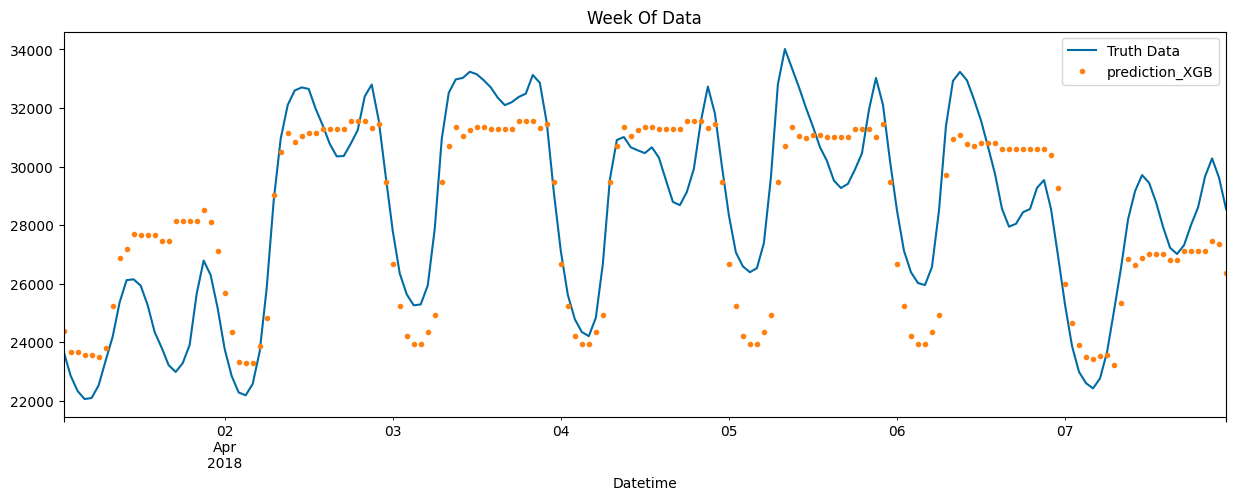

In [ ]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction_XGB'] \
    .plot(style='.')
plt.legend(['Truth Data','prediction_XGB'])
plt.show()

In [ ]:
test['prediction_XGB'] = regXGB.predict(X_test)
df = df.merge(test[['prediction_XGB']], how='left', left_index=True, right_index=True)

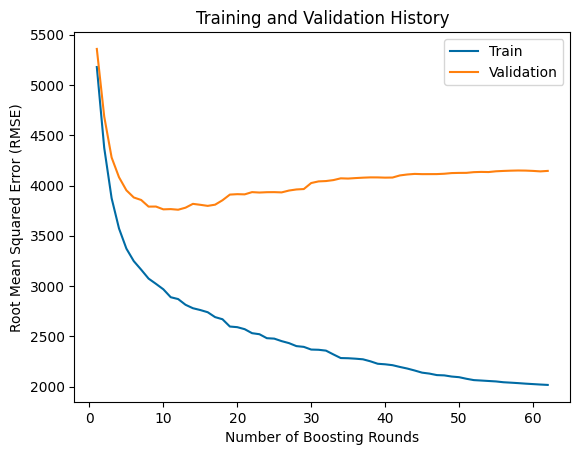

In [ ]:
# Ploteo del historial de entrenamiento y validacion
resultsXGB = regXGB.evals_result()
train_error = resultsXGB['validation_0']['rmse']
val_error = resultsXGB['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Training and Validation History')
plt.legend()
plt.show()

Este gráfico es útil para visualizar cómo cambian los errores de entrenamiento y validación a medida que avanza el entrenamiento del modelo. Vemos que hay overfitting fuerte porque el error de validacion empieza a aumentar pero el de train sigue bajando.

Entonces, cuando vemos overfitting, uno de los hiperparámetros clave que podemos ajustar es max_depth, que controla la profundidad máxima de cada árbol en el modelo.
queda pendiente para el alumno.

In [ ]:
test['error_XGB'] = np.abs(test[TARGET]- test['prediction_XGB'])

In [ ]:
test['date']= test.index.date

In [ ]:
# mejores predicciones
test.groupby('date')['error_XGB'].mean().sort_values(ascending=True).head(10)

date
2015-10-28    393.196777
2016-10-27    396.577962
2017-10-24    397.313151
2016-04-04    485.579671
2017-05-02    486.732096
2016-08-08    487.442057
2016-01-12    494.333333
2018-02-06    509.856201
2016-09-27    531.468099
2016-03-20    533.059814
Name: error_XGB, dtype: float64

In [ ]:
# Peores predicciones
test.groupby('date')['error_XGB'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    14143.731527
2016-08-14    13856.622559
2016-09-10    11566.011149
2016-08-12    11432.267822
2016-09-09    10429.431315
2015-02-20    10402.748210
2018-01-06    10350.334880
2018-01-07    10209.427734
2017-12-31    10133.405924
2016-07-23     9945.256999
Name: error_XGB, dtype: float64

# Lightgbm

In [ ]:
reg_lightgbm = lgb.LGBMRegressor(n_estimators=1000, early_stopping_round=50)
reg_lightgbm.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Info] Start training from score 32289.296912
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	training's l2: 8.25944e+06	valid_1's l2: 1.43882e+07


LGBMRegressor(early_stopping_round=50, n_estimators=1000)

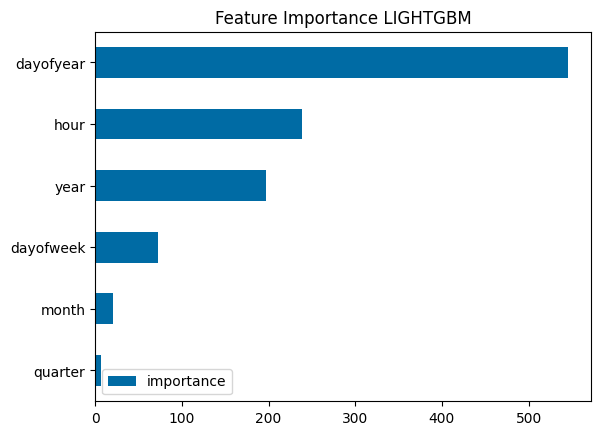

In [ ]:
fi = pd.DataFrame(data=reg_lightgbm.feature_importances_,
             index=reg_lightgbm.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance LIGHTGBM')
plt.show()

Vemos los features mas importantes, ¿ que podriamos hacer ?

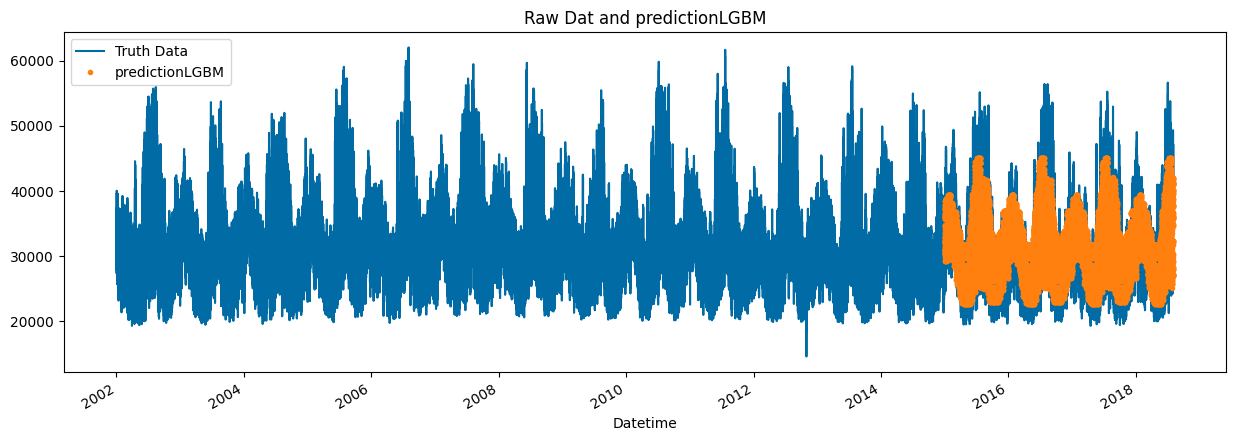

In [ ]:
test['predictionLGBM'] = reg_lightgbm.predict(X_test)
df = df.merge(test[['predictionLGBM']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['predictionLGBM'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'predictionLGBM'])
ax.set_title('Raw Dat and predictionLGBM')
plt.show()

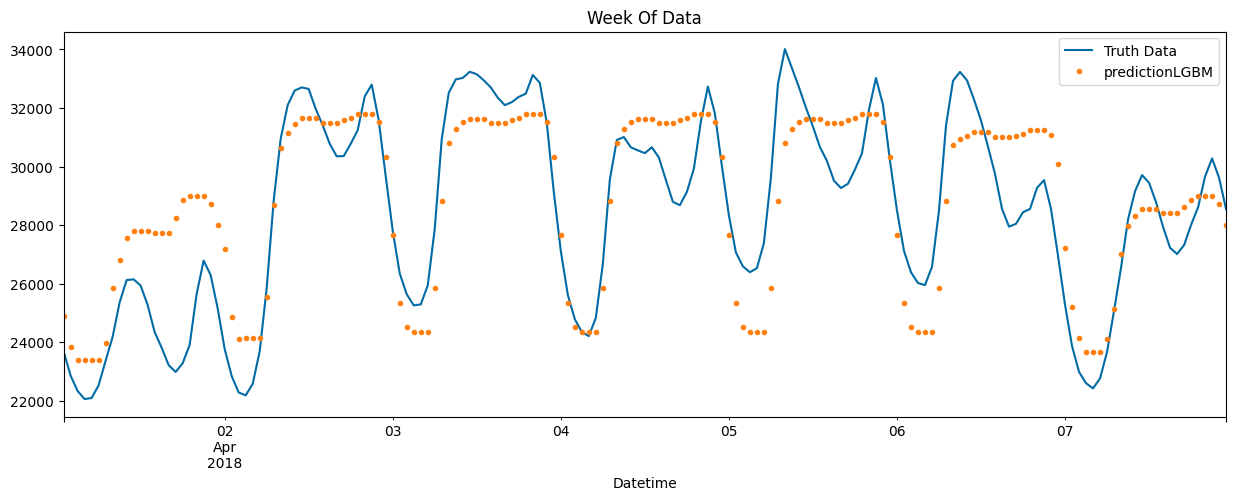

In [ ]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['predictionLGBM'] \
    .plot(style='.')
plt.legend(['Truth Data','predictionLGBM'])
plt.show()

In [ ]:
test['predictionLGBM'] = reg_lightgbm.predict(X_test)
df = df.merge(test[['predictionLGBM']], how='left', left_index=True, right_index=True)

In [ ]:
test['error_LGBM'] = np.abs(test[TARGET]- test['predictionLGBM'])

In [ ]:
# mejores predicciones
test.groupby('date')['error_LGBM'].mean().sort_values(ascending=True).head(10)

date
2016-12-12    502.471089
2018-05-16    516.519748
2016-06-03    522.777376
2015-03-04    529.273149
2016-12-30    550.745883
2015-07-13    562.454955
2016-12-29    584.123048
2017-10-24    610.826337
2016-01-12    611.610504
2015-05-06    622.679773
Name: error_LGBM, dtype: float64

In [ ]:
# Peores predicciones
test.groupby('date')['error_LGBM'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    13199.257366
2016-08-14    12949.947182
2016-09-10    11903.579303
2016-08-12    11378.966696
2016-09-09    11241.815077
2018-01-06    11128.094718
2015-02-20    10685.516437
2018-01-07    10346.858628
2016-07-23     9849.527269
2016-08-11     9703.573238
Name: error_LGBM, dtype: float64

Vemos las mejores y peores predicciones, ¿ se puede hacer algun analisis ?

Metricas Globales

In [ ]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['predictionLGBM']))
print(f'RMSE en conjunto de Test Modelo LGBM: {score:0.2f}')

RMSE en conjunto de Test Modelo LGBM: 3793.18


In [ ]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction_XGB']))
print(f'RMSE en conjunto de Test. Modelo XGBoost: {score:0.2f}')

RMSE en conjunto de Test. Modelo XGBoost: 3759.12


Al momento estos son las metricas encontradas. ¿ se pueden mejorar ? - Probamos con LightGBM

Optuna ( optimización automatizado de hiperparámetros)

https://optuna.readthedocs.io/en/stable/

In [ ]:
# ! pip install optuna

In [ ]:
import optuna

def objective(trial):
    param = {
        "n_estimators": 2000,
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 0.01, 1.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 0.01, 1.0),
    }

    model = lgb.LGBMRegressor(**param, early_stopping_rounds=50)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])








    # Puedes usar la métrica de tu preferencia aquí
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)
print(study.best_params)


[I 2024-10-21 16:13:01,307] A new study created in memory with name: no-name-f8aa4c80-fba9-4f13-a8e2-ab6ab589d713
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
<ipython-input-43-9765b50d9a61>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
Training until validation scores don't improve for 50 rounds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:13:02,201] Trial 0 finished with value: 3791.4363343500727 and parameters: {'learning_rate': 0.09714203745426646, 'max_depth': 7, 'num_leaves': 48, 'min_child_samples': 32, 'subsample': 0.5157323629020498, 'colsample_bytree': 0.9190159228561827, 'reg_alpha': 0.3616502005594813, 'reg_lambda': 0.31676997311557636}. Best is trial 0 with value: 3791.4363343500727.


Early stopping, best iteration is:
[33]	training's l2: 8.3941e+06	valid_1's l2: 1.4375e+07
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
Training until validation scores don't improve for 50 rounds


<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
<ipython-input-43-9765b50d9a61>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
<ipython-input-43-9765b50d9a61>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Early stopping, best iteration is:
[784]	training's l2: 8.14182e+06	valid_1's l2: 1.3909e+07


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:13:12,593] Trial 1 finished with value: 3729.4732063197393 and parameters: {'learning_rate': 0.00602159168293492, 'max_depth': 9, 'num_leaves': 24, 'min_child_samples': 67, 'subsample': 0.6778646765825436, 'colsample_bytree': 0.7043128556612228, 'reg_alpha': 0.04675781366853571, 'reg_lambda': 0.3340978794575914}. Best is trial 1 with value: 3729.4732063197393.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWarn

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
Training until validation scores don't improve for 50 rounds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:13:13,732] Trial 2 finished with value: 3753.5952823701714 and parameters: {'learning_rate': 0.0558663690403694, 'max_depth': 7, 'num_leaves': 36, 'min_child_samples': 44, 'subsample': 0.8291465765505569, 'colsample_bytree': 0.7744170413856193, 'reg_alpha': 0.33400533514579345, 'reg_lambda': 0.7869192149783709}. Best is trial 1 with value: 3729.4732063197393.


Early stopping, best iteration is:
[66]	training's l2: 8.26131e+06	valid_1's l2: 1.40895e+07
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50


<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
<ipython-input-43-9765b50d9a61>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
<ipython-input-43-9765b50d9a61>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

[LightGBM] [Info] Start training from score 32289.296912
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[664]	training's l2: 8.262e+06	valid_1's l2: 1.40807e+07


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:13:22,737] Trial 3 finished with value: 3752.421025556156 and parameters: {'learning_rate': 0.005647315252186063, 'max_depth': 6, 'num_leaves': 52, 'min_child_samples': 38, 'subsample': 0.8203638256978716, 'colsample_bytree': 0.7648824117674116, 'reg_alpha': 0.022250828219839435, 'reg_lambda': 0.9287578722841714}. Best is trial 1 with value: 3729.4732063197393.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWar

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[473]	training's l2: 8.67055e+06	valid_1's l2: 1.42107e+07


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:13:28,449] Trial 4 finished with value: 3769.705062903364 and parameters: {'learning_rate': 0.006152449455463401, 'max_depth': 7, 'num_leaves': 54, 'min_child_samples': 83, 'subsample': 0.6348638935298954, 'colsample_bytree': 0.9671483458346382, 'reg_alpha': 0.042875196305587046, 'reg_lambda': 0.015749034332939553}. Best is trial 1 with value: 3729.4732063197393.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureW

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:13:29,419] Trial 5 finished with value: 3678.232673676712 and parameters: {'learning_rate': 0.07701963449840743, 'max_depth': 4, 'num_leaves': 126, 'min_child_samples': 11, 'subsample': 0.5888493348352839, 'colsample_bytree': 0.74378700158041, 'reg_alpha': 0.8721766892204481, 'reg_lambda': 0.3259692690089537}. Best is trial 5 with value: 3678.232673676712.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[70]	training's l2: 9.31255e+06	valid_1's l2: 1.35294e+07
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50


<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
<ipython-input-43-9765b50d9a61>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
<ipython-input-43-9765b50d9a61>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:13:57,911] Trial 6 finished with value: 3804.2684696888286 and parameters: {'learning_rate': 0.001263262586244322, 'max_depth': 6, 'num_leaves': 120, 'min_child_samples': 25, 'subsample': 0.5376924461945252, 'colsample_bytree': 0.827470949467326, 'reg_alpha': 0.242993299039671, 'reg_lambda': 0.4167914419047901}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWarnin

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2000]	training's l2: 1.03481e+07	valid_1's l2: 1.50123e+07


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:14:21,657] Trial 7 finished with value: 3874.5654321746983 and parameters: {'learning_rate': 0.0013102335112390843, 'max_depth': 10, 'num_leaves': 23, 'min_child_samples': 39, 'subsample': 0.6103332776985814, 'colsample_bytree': 0.699143909565604, 'reg_alpha': 0.5818543983689145, 'reg_lambda': 0.7994265284647246}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWarn

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:14:31,509] Trial 8 finished with value: 3723.125086755476 and parameters: {'learning_rate': 0.010521007351280606, 'max_depth': 3, 'num_leaves': 128, 'min_child_samples': 65, 'subsample': 0.5256611860694351, 'colsample_bytree': 0.7551811585486068, 'reg_alpha': 0.5058457089090835, 'reg_lambda': 0.0730255478602469}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWarni

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:14:32,723] Trial 9 finished with value: 3942.079840647983 and parameters: {'learning_rate': 0.09317348709274957, 'max_depth': 9, 'num_leaves': 129, 'min_child_samples': 75, 'subsample': 0.8866591544582726, 'colsample_bytree': 0.5492138868016325, 'reg_alpha': 0.11849492820758262, 'reg_lambda': 0.01704516169225211}. Best is trial 5 with value: 3678.232673676712.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[45]	training's l2: 6.5294e+06	valid_1's l2: 1.554e+07


<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
<ipython-input-43-9765b50d9a61>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
<ipython-input-43-9765b50d9a61>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:14:36,430] Trial 10 finished with value: 3726.741322615208 and parameters: {'learning_rate': 0.02660196830673095, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 12, 'subsample': 0.7606578267073644, 'colsample_bytree': 0.5729756123144463, 'reg_alpha': 0.01069333526528553, 'reg_lambda': 0.09426923539387122}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWarn

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:14:42,721] Trial 11 finished with value: 3729.466401232424 and parameters: {'learning_rate': 0.021121710300327726, 'max_depth': 3, 'num_leaves': 150, 'min_child_samples': 99, 'subsample': 0.5853002226477013, 'colsample_bytree': 0.6382467429366492, 'reg_alpha': 0.8981756667720504, 'reg_lambda': 0.0765073090643661}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWarn

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:14:45,839] Trial 12 finished with value: 3706.1721782413206 and parameters: {'learning_rate': 0.016418336122000544, 'max_depth': 4, 'num_leaves': 97, 'min_child_samples': 58, 'subsample': 0.9939793605913467, 'colsample_bytree': 0.8530245432548637, 'reg_alpha': 0.8356763876441878, 'reg_lambda': 0.044990522323154446}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWa

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:14:47,669] Trial 13 finished with value: 3700.3922486159718 and parameters: {'learning_rate': 0.03300286200429035, 'max_depth': 5, 'num_leaves': 96, 'min_child_samples': 53, 'subsample': 0.9821727094032746, 'colsample_bytree': 0.8682887107685846, 'reg_alpha': 0.9396881111122819, 'reg_lambda': 0.03303738462553507}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWarn

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:14:49,096] Trial 14 finished with value: 3704.8446047135917 and parameters: {'learning_rate': 0.041735684317418385, 'max_depth': 5, 'num_leaves': 109, 'min_child_samples': 11, 'subsample': 0.996824032812347, 'colsample_bytree': 0.8823101447326271, 'reg_alpha': 0.1690138128418877, 'reg_lambda': 0.03024447233847465}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWar

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:14:50,349] Trial 15 finished with value: 3701.2775960381564 and parameters: {'learning_rate': 0.04926214298780306, 'max_depth': 5, 'num_leaves': 73, 'min_child_samples': 50, 'subsample': 0.7066757616071253, 'colsample_bytree': 0.9647678812729317, 'reg_alpha': 0.9898477315996442, 'reg_lambda': 0.16824134825756354}. Best is trial 5 with value: 3678.232673676712.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[77]	training's l2: 9.13768e+06	valid_1's l2: 1.36995e+07
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50


<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
<ipython-input-43-9765b50d9a61>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
<ipython-input-43-9765b50d9a61>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:14:51,922] Trial 16 finished with value: 3705.441261721651 and parameters: {'learning_rate': 0.038639431639364424, 'max_depth': 5, 'num_leaves': 74, 'min_child_samples': 28, 'subsample': 0.9021766693090703, 'colsample_bytree': 0.811202687112334, 'reg_alpha': 0.07386623007398456, 'reg_lambda': 0.1755868105717151}. Best is trial 5 with value: 3678.232673676712.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[112]	training's l2: 8.82009e+06	valid_1's l2: 1.37303e+07


<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
<ipython-input-43-9765b50d9a61>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
<ipython-input-43-9765b50d9a61>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:14:57,386] Trial 17 finished with value: 3683.588302557831 and parameters: {'learning_rate': 0.01276090215851363, 'max_depth': 4, 'num_leaves': 144, 'min_child_samples': 92, 'subsample': 0.7616566180616307, 'colsample_bytree': 0.6739944398605637, 'reg_alpha': 0.23099710582575844, 'reg_lambda': 0.0310840763678453}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWarn

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:15:17,606] Trial 18 finished with value: 3688.9996773389194 and parameters: {'learning_rate': 0.0029523976950569155, 'max_depth': 4, 'num_leaves': 144, 'min_child_samples': 77, 'subsample': 0.7536225379748801, 'colsample_bytree': 0.6230316198293538, 'reg_alpha': 0.1886484039546081, 'reg_lambda': 0.17139077349694998}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureW

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:15:23,088] Trial 19 finished with value: 3687.6200625327515 and parameters: {'learning_rate': 0.011352693591549893, 'max_depth': 4, 'num_leaves': 137, 'min_child_samples': 84, 'subsample': 0.6915791100086548, 'colsample_bytree': 0.6938575153020032, 'reg_alpha': 0.09657281599770437, 'reg_lambda': 0.011532231877080098}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: Future

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:15:42,629] Trial 20 finished with value: 3716.779906895042 and parameters: {'learning_rate': 0.0022270384903663905, 'max_depth': 4, 'num_leaves': 110, 'min_child_samples': 96, 'subsample': 0.8160039518257334, 'colsample_bytree': 0.6445092468819238, 'reg_alpha': 0.48162331729237834, 'reg_lambda': 0.05048777604036441}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureW

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:15:47,338] Trial 21 finished with value: 3684.123811730687 and parameters: {'learning_rate': 0.010554025395924916, 'max_depth': 4, 'num_leaves': 140, 'min_child_samples': 89, 'subsample': 0.6716068802539584, 'colsample_bytree': 0.6911927056054398, 'reg_alpha': 0.05252007810281719, 'reg_lambda': 0.012194315141406684}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureW

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:15:53,775] Trial 22 finished with value: 3741.544744650766 and parameters: {'learning_rate': 0.015838154262841634, 'max_depth': 3, 'num_leaves': 134, 'min_child_samples': 91, 'subsample': 0.6438029893531672, 'colsample_bytree': 0.5909764585684849, 'reg_alpha': 0.053997405526481516, 'reg_lambda': 0.021076783467530565}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: Future

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:16:10,917] Trial 23 finished with value: 3683.2730395364306 and parameters: {'learning_rate': 0.0033653534966942805, 'max_depth': 4, 'num_leaves': 119, 'min_child_samples': 85, 'subsample': 0.5741685629722543, 'colsample_bytree': 0.6756114760856404, 'reg_alpha': 0.02749154815760256, 'reg_lambda': 0.012521359954987293}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: Futur

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:16:29,413] Trial 24 finished with value: 3752.0900923745803 and parameters: {'learning_rate': 0.0035408404313860024, 'max_depth': 6, 'num_leaves': 114, 'min_child_samples': 72, 'subsample': 0.5661441701112466, 'colsample_bytree': 0.6610614794428904, 'reg_alpha': 0.025046558381560797, 'reg_lambda': 0.02835884229176816}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: Futur

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:16:51,836] Trial 25 finished with value: 3803.6718739869825 and parameters: {'learning_rate': 0.0019202602074482223, 'max_depth': 5, 'num_leaves': 124, 'min_child_samples': 20, 'subsample': 0.5744853839768725, 'colsample_bytree': 0.5065711343458398, 'reg_alpha': 0.01014079785632004, 'reg_lambda': 0.022042778251527357}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: Futur

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:17:04,933] Trial 26 finished with value: 3686.187724858376 and parameters: {'learning_rate': 0.004362559592018383, 'max_depth': 4, 'num_leaves': 150, 'min_child_samples': 61, 'subsample': 0.7274404319817451, 'colsample_bytree': 0.7340921107653917, 'reg_alpha': 0.02330074480477876, 'reg_lambda': 0.010163210397650942}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureW

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[374]	training's l2: 7.62509e+06	valid_1's l2: 1.44234e+07


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:17:10,523] Trial 27 finished with value: 3797.811936417839 and parameters: {'learning_rate': 0.007581210566749949, 'max_depth': 8, 'num_leaves': 102, 'min_child_samples': 83, 'subsample': 0.7915210069596411, 'colsample_bytree': 0.6062340353361643, 'reg_alpha': 0.11307898004773789, 'reg_lambda': 0.04839334742044418}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWa

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:17:13,306] Trial 28 finished with value: 3720.5040678534206 and parameters: {'learning_rate': 0.07319989697845371, 'max_depth': 3, 'num_leaves': 118, 'min_child_samples': 92, 'subsample': 0.636061002288573, 'colsample_bytree': 0.8056495511152371, 'reg_alpha': 0.017008821177755887, 'reg_lambda': 0.48555682259577876}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWa

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:17:34,289] Trial 29 finished with value: 3748.9970264705885 and parameters: {'learning_rate': 0.0024907657038835693, 'max_depth': 6, 'num_leaves': 78, 'min_child_samples': 99, 'subsample': 0.5063622102437377, 'colsample_bytree': 0.728370871289065, 'reg_alpha': 0.3065820524775435, 'reg_lambda': 0.2514137016434356}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWarn

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:17:48,744] Trial 30 finished with value: 3726.3451587096733 and parameters: {'learning_rate': 0.004122220492086275, 'max_depth': 5, 'num_leaves': 133, 'min_child_samples': 78, 'subsample': 0.8725460981973319, 'colsample_bytree': 0.6677541637480322, 'reg_alpha': 0.2028734242232829, 'reg_lambda': 0.12674379479153844}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWa

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:17:53,674] Trial 31 finished with value: 3682.3519291966786 and parameters: {'learning_rate': 0.01263032856816507, 'max_depth': 4, 'num_leaves': 139, 'min_child_samples': 91, 'subsample': 0.6756827975487205, 'colsample_bytree': 0.6749129236455275, 'reg_alpha': 0.03028327999358618, 'reg_lambda': 0.012343547651698324}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureW

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:17:57,741] Trial 32 finished with value: 3684.1861348518432 and parameters: {'learning_rate': 0.015531651011248912, 'max_depth': 4, 'num_leaves': 143, 'min_child_samples': 88, 'subsample': 0.611143085540878, 'colsample_bytree': 0.7248578013957016, 'reg_alpha': 0.02922851055109919, 'reg_lambda': 0.01521463496419565}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWa

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:18:07,708] Trial 33 finished with value: 3730.481020152472 and parameters: {'learning_rate': 0.0077829762109421705, 'max_depth': 3, 'num_leaves': 123, 'min_child_samples': 66, 'subsample': 0.6648969192447535, 'colsample_bytree': 0.6668883156351465, 'reg_alpha': 0.03553834155106521, 'reg_lambda': 0.018342777330460778}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: Future

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:18:10,386] Trial 34 finished with value: 3685.400642034661 and parameters: {'learning_rate': 0.02719197399674846, 'max_depth': 4, 'num_leaves': 106, 'min_child_samples': 70, 'subsample': 0.7211075052151593, 'colsample_bytree': 0.7685163767108089, 'reg_alpha': 0.016519589106678226, 'reg_lambda': 0.02445698008384382}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWa

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:18:20,852] Trial 35 finished with value: 3723.5812696624 and parameters: {'learning_rate': 0.005352049015954217, 'max_depth': 5, 'num_leaves': 142, 'min_child_samples': 94, 'subsample': 0.5534798647248713, 'colsample_bytree': 0.7135953279581823, 'reg_alpha': 0.07248801173803006, 'reg_lambda': 0.037329936974348374}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWar

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:18:22,783] Trial 36 finished with value: 3955.1564112540245 and parameters: {'learning_rate': 0.06099648691126454, 'max_depth': 8, 'num_leaves': 130, 'min_child_samples': 47, 'subsample': 0.5990777650596213, 'colsample_bytree': 0.5585838034994295, 'reg_alpha': 0.016169939390128722, 'reg_lambda': 0.013106901745063968}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: Future

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2000]	training's l2: 9.09707e+06	valid_1's l2: 1.42027e+07


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:18:47,198] Trial 37 finished with value: 3768.6419292281284 and parameters: {'learning_rate': 0.0015488905943989867, 'max_depth': 6, 'num_leaves': 39, 'min_child_samples': 82, 'subsample': 0.6599133187424968, 'colsample_bytree': 0.6754725821555588, 'reg_alpha': 0.036791429389074724, 'reg_lambda': 0.5619358277688553}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureW

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:19:05,032] Trial 38 finished with value: 4338.3898162688465 and parameters: {'learning_rate': 0.001017208655397783, 'max_depth': 3, 'num_leaves': 118, 'min_child_samples': 36, 'subsample': 0.7766727097356239, 'colsample_bytree': 0.7971957590263334, 'reg_alpha': 0.6687710394936635, 'reg_lambda': 0.35595308495474126}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWa

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[435]	training's l2: 7.80744e+06	valid_1's l2: 1.42459e+07


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:19:10,637] Trial 39 finished with value: 3774.3729536496403 and parameters: {'learning_rate': 0.008018309158991772, 'max_depth': 7, 'num_leaves': 65, 'min_child_samples': 100, 'subsample': 0.6166333533125963, 'colsample_bytree': 0.7506080597152268, 'reg_alpha': 0.31425344025083957, 'reg_lambda': 0.23323944471666064}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureW

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:19:20,602] Trial 40 finished with value: 3712.3606332551403 and parameters: {'learning_rate': 0.006117526285987689, 'max_depth': 4, 'num_leaves': 136, 'min_child_samples': 85, 'subsample': 0.5503621242817778, 'colsample_bytree': 0.780756803923127, 'reg_alpha': 0.13693475842229103, 'reg_lambda': 0.06754898633159158}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWa

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:19:25,833] Trial 41 finished with value: 3682.9314554168295 and parameters: {'learning_rate': 0.012235988890005442, 'max_depth': 4, 'num_leaves': 142, 'min_child_samples': 91, 'subsample': 0.6847400226611768, 'colsample_bytree': 0.6890087487434065, 'reg_alpha': 0.06019001421994335, 'reg_lambda': 0.012234524423460085}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: Future

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:19:31,535] Trial 42 finished with value: 3678.2437876999215 and parameters: {'learning_rate': 0.0129777583709106, 'max_depth': 4, 'num_leaves': 150, 'min_child_samples': 87, 'subsample': 0.6974338098638418, 'colsample_bytree': 0.6371499900336395, 'reg_alpha': 0.06952573680551156, 'reg_lambda': 0.01432431691102741}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWar

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:19:36,392] Trial 43 finished with value: 3730.6789005470364 and parameters: {'learning_rate': 0.02071673887296387, 'max_depth': 3, 'num_leaves': 150, 'min_child_samples': 78, 'subsample': 0.6887734166891415, 'colsample_bytree': 0.633784674868286, 'reg_alpha': 0.07221134391552608, 'reg_lambda': 0.013508391643522532}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWa

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:19:37,448] Trial 44 finished with value: 3702.651505787128 and parameters: {'learning_rate': 0.09617292817275801, 'max_depth': 5, 'num_leaves': 127, 'min_child_samples': 87, 'subsample': 0.7322643883398585, 'colsample_bytree': 0.6087775986963867, 'reg_alpha': 0.04469046999920648, 'reg_lambda': 0.010363057710938513}. Best is trial 5 with value: 3678.232673676712.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[49]	training's l2: 8.51369e+06	valid_1's l2: 1.37096e+07


<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
<ipython-input-43-9765b50d9a61>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
<ipython-input-43-9765b50d9a61>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[116]	training's l2: 7.05979e+06	valid_1's l2: 1.45899e+07


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:19:39,809] Trial 45 finished with value: 3819.6770692665195 and parameters: {'learning_rate': 0.023161069840221718, 'max_depth': 10, 'num_leaves': 131, 'min_child_samples': 41, 'subsample': 0.6436106569979568, 'colsample_bytree': 0.7051835652863218, 'reg_alpha': 0.034368921153893915, 'reg_lambda': 0.01794606379321102}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: Futur

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:19:45,112] Trial 46 finished with value: 3685.8209618777046 and parameters: {'learning_rate': 0.014364209972329307, 'max_depth': 4, 'num_leaves': 138, 'min_child_samples': 18, 'subsample': 0.5268008288977087, 'colsample_bytree': 0.6448546803614142, 'reg_alpha': 0.061802037286130776, 'reg_lambda': 0.0146355536016717}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureW

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:19:55,554] Trial 47 finished with value: 3722.1675069424105 and parameters: {'learning_rate': 0.009489250156734635, 'max_depth': 3, 'num_leaves': 123, 'min_child_samples': 81, 'subsample': 0.5924313041762692, 'colsample_bytree': 0.7335344927839957, 'reg_alpha': 0.08669889046828373, 'reg_lambda': 0.019896513921749754}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: Future

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:19:59,895] Trial 48 finished with value: 3753.633116886861 and parameters: {'learning_rate': 0.019302578253540197, 'max_depth': 5, 'num_leaves': 146, 'min_child_samples': 95, 'subsample': 0.7072676969982604, 'colsample_bytree': 0.5224096679642273, 'reg_alpha': 0.028875908193798205, 'reg_lambda': 0.6915836150136563}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWa

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:20:02,039] Trial 49 finished with value: 3750.1830390925093 and parameters: {'learning_rate': 0.02883253642386789, 'max_depth': 6, 'num_leaves': 89, 'min_child_samples': 61, 'subsample': 0.6286788778902913, 'colsample_bytree': 0.8349495429898066, 'reg_alpha': 0.018860855219665386, 'reg_lambda': 0.016278044430770133}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureW

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:20:19,464] Trial 50 finished with value: 3705.029885714974 and parameters: {'learning_rate': 0.004944212852047988, 'max_depth': 4, 'num_leaves': 116, 'min_child_samples': 73, 'subsample': 0.5796876168611879, 'colsample_bytree': 0.5788803861627806, 'reg_alpha': 0.013178861654963918, 'reg_lambda': 0.025492284217796177}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: Future

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:20:24,107] Trial 51 finished with value: 3680.4833609479083 and parameters: {'learning_rate': 0.012611825899459368, 'max_depth': 4, 'num_leaves': 142, 'min_child_samples': 92, 'subsample': 0.7501486317146437, 'colsample_bytree': 0.6565852762535682, 'reg_alpha': 0.13410705257280622, 'reg_lambda': 0.0389303455832168}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWa

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:20:29,474] Trial 52 finished with value: 3684.60390111949 and parameters: {'learning_rate': 0.012099251716618149, 'max_depth': 4, 'num_leaves': 138, 'min_child_samples': 88, 'subsample': 0.7438609913846427, 'colsample_bytree': 0.6833483595482571, 'reg_alpha': 0.14757336404647153, 'reg_lambda': 0.05953271251910001}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWar

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:20:42,861] Trial 53 finished with value: 3718.795034482044 and parameters: {'learning_rate': 0.008415254222419781, 'max_depth': 3, 'num_leaves': 127, 'min_child_samples': 94, 'subsample': 0.692645951909472, 'colsample_bytree': 0.6198011007533749, 'reg_alpha': 0.04176655129387196, 'reg_lambda': 0.039718351512214485}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWa

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:20:48,531] Trial 54 finished with value: 3719.239612686203 and parameters: {'learning_rate': 0.009969023773562732, 'max_depth': 5, 'num_leaves': 145, 'min_child_samples': 97, 'subsample': 0.8027690858672099, 'colsample_bytree': 0.6511998654398852, 'reg_alpha': 0.05826485896614851, 'reg_lambda': 0.012045217503208857}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureW

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:20:53,245] Trial 55 finished with value: 3685.969187875971 and parameters: {'learning_rate': 0.013112664314896903, 'max_depth': 4, 'num_leaves': 134, 'min_child_samples': 90, 'subsample': 0.8563336520442574, 'colsample_bytree': 0.7059458458404286, 'reg_alpha': 0.09487139586052638, 'reg_lambda': 0.10723923398015642}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWa

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:20:59,219] Trial 56 finished with value: 3730.8981908406645 and parameters: {'learning_rate': 0.017590028779679835, 'max_depth': 3, 'num_leaves': 148, 'min_child_samples': 80, 'subsample': 0.769296393356741, 'colsample_bytree': 0.5996236532477369, 'reg_alpha': 0.46626187561639154, 'reg_lambda': 0.010358469038289832}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureW

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:21:01,271] Trial 57 finished with value: 3689.1378265016033 and parameters: {'learning_rate': 0.036114005763257045, 'max_depth': 4, 'num_leaves': 142, 'min_child_samples': 32, 'subsample': 0.7107689685608545, 'colsample_bytree': 0.6301591658930417, 'reg_alpha': 0.3993515475310794, 'reg_lambda': 0.014943698719911323}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureW

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:21:10,617] Trial 58 finished with value: 3716.5954422850145 and parameters: {'learning_rate': 0.006806770725553378, 'max_depth': 5, 'num_leaves': 140, 'min_child_samples': 86, 'subsample': 0.6797880124052437, 'colsample_bytree': 0.6870302790832593, 'reg_alpha': 0.02733626225704241, 'reg_lambda': 0.022751095448302713}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: Future

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:21:13,100] Trial 59 finished with value: 3697.930934540283 and parameters: {'learning_rate': 0.022938512136236287, 'max_depth': 4, 'num_leaves': 113, 'min_child_samples': 75, 'subsample': 0.743506692844011, 'colsample_bytree': 0.910769584808039, 'reg_alpha': 0.020121470682632984, 'reg_lambda': 0.0924192164600714}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWarn

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:21:14,318] Trial 60 finished with value: 3691.8962282103203 and parameters: {'learning_rate': 0.07844031883902496, 'max_depth': 5, 'num_leaves': 121, 'min_child_samples': 93, 'subsample': 0.6481004381957112, 'colsample_bytree': 0.7494195577927087, 'reg_alpha': 0.7153117966506244, 'reg_lambda': 0.02728120083756964}. Best is trial 5 with value: 3678.232673676712.


Early stopping, best iteration is:
[59]	training's l2: 8.65197e+06	valid_1's l2: 1.36301e+07
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50


<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
<ipython-input-43-9765b50d9a61>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
<ipython-input-43-9765b50d9a61>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:21:18,476] Trial 61 finished with value: 3682.921937106313 and parameters: {'learning_rate': 0.013107127059981592, 'max_depth': 4, 'num_leaves': 145, 'min_child_samples': 97, 'subsample': 0.7870580777532311, 'colsample_bytree': 0.6565858491178951, 'reg_alpha': 0.24870549224050206, 'reg_lambda': 0.012239556191657189}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureW

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:21:23,995] Trial 62 finished with value: 3686.925062050545 and parameters: {'learning_rate': 0.013315054269794898, 'max_depth': 4, 'num_leaves': 133, 'min_child_samples': 97, 'subsample': 0.9272498120344954, 'colsample_bytree': 0.6541700624619523, 'reg_alpha': 0.27033710757217705, 'reg_lambda': 0.01209220149096116}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWa

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:21:25,546] Trial 63 finished with value: 3689.52667253958 and parameters: {'learning_rate': 0.04866246629037728, 'max_depth': 4, 'num_leaves': 147, 'min_child_samples': 90, 'subsample': 0.7971595689432068, 'colsample_bytree': 0.7100295384627449, 'reg_alpha': 0.0828678149141931, 'reg_lambda': 0.018541619812250058}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWarn

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:21:29,522] Trial 64 finished with value: 3743.1338576522903 and parameters: {'learning_rate': 0.018007014963498297, 'max_depth': 3, 'num_leaves': 127, 'min_child_samples': 99, 'subsample': 0.83954976812075, 'colsample_bytree': 0.6890500261579696, 'reg_alpha': 0.11820495762924714, 'reg_lambda': 0.013730165349835692}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWa

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:21:37,570] Trial 65 finished with value: 3718.996019882682 and parameters: {'learning_rate': 0.009186573820973147, 'max_depth': 5, 'num_leaves': 138, 'min_child_samples': 85, 'subsample': 0.7785974139822598, 'colsample_bytree': 0.6173455969531476, 'reg_alpha': 0.14815473223112036, 'reg_lambda': 0.016837619117819273}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureW

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:21:42,461] Trial 66 finished with value: 3717.1380824658045 and parameters: {'learning_rate': 0.012284152406650192, 'max_depth': 4, 'num_leaves': 150, 'min_child_samples': 92, 'subsample': 0.8246153439808416, 'colsample_bytree': 0.9991086988295159, 'reg_alpha': 0.04907503931053065, 'reg_lambda': 0.011215977037938283}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: Future

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[968]	training's l2: 6.73424e+06	valid_1's l2: 1.46797e+07


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:22:00,681] Trial 67 finished with value: 3831.404889406155 and parameters: {'learning_rate': 0.0030747991847451645, 'max_depth': 9, 'num_leaves': 144, 'min_child_samples': 52, 'subsample': 0.6579371595757492, 'colsample_bytree': 0.6725178798989222, 'reg_alpha': 0.06370658886243659, 'reg_lambda': 0.020960861259007812}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: Future

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:22:07,123] Trial 68 finished with value: 3688.846444663723 and parameters: {'learning_rate': 0.011121949005333394, 'max_depth': 4, 'num_leaves': 135, 'min_child_samples': 88, 'subsample': 0.7168802351865827, 'colsample_bytree': 0.5834013062782887, 'reg_alpha': 0.2440174190984657, 'reg_lambda': 0.9450117197618664}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWarn

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:22:12,447] Trial 69 finished with value: 3737.265886057508 and parameters: {'learning_rate': 0.015479587651965289, 'max_depth': 3, 'num_leaves': 28, 'min_child_samples': 96, 'subsample': 0.6203064426135345, 'colsample_bytree': 0.7197738590139965, 'reg_alpha': 0.17967938724747756, 'reg_lambda': 0.03312389877521195}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWar

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:22:23,803] Trial 70 finished with value: 3715.642544762253 and parameters: {'learning_rate': 0.006854887658242231, 'max_depth': 5, 'num_leaves': 130, 'min_child_samples': 70, 'subsample': 0.7535594406043347, 'colsample_bytree': 0.6609033099965772, 'reg_alpha': 0.04040366385553588, 'reg_lambda': 0.013237718366043929}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureW

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:22:29,365] Trial 71 finished with value: 3682.038702380858 and parameters: {'learning_rate': 0.010134536791924671, 'max_depth': 4, 'num_leaves': 141, 'min_child_samples': 92, 'subsample': 0.7316961778911174, 'colsample_bytree': 0.6343733923084638, 'reg_alpha': 0.10661168290495071, 'reg_lambda': 0.010046537833093457}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureW

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:22:35,568] Trial 72 finished with value: 3686.926068764026 and parameters: {'learning_rate': 0.010845461320760457, 'max_depth': 4, 'num_leaves': 140, 'min_child_samples': 91, 'subsample': 0.6979107251258928, 'colsample_bytree': 0.6404245245203632, 'reg_alpha': 0.10752237750177367, 'reg_lambda': 0.01026102577618102}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWa

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:22:41,748] Trial 73 finished with value: 3682.337352535908 and parameters: {'learning_rate': 0.00897242689525922, 'max_depth': 4, 'num_leaves': 145, 'min_child_samples': 100, 'subsample': 0.7357968302955556, 'colsample_bytree': 0.6284378615632855, 'reg_alpha': 0.21287857229583618, 'reg_lambda': 0.01575084057681752}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWa

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:22:52,688] Trial 74 finished with value: 3710.977348461798 and parameters: {'learning_rate': 0.008789761865484963, 'max_depth': 4, 'num_leaves': 146, 'min_child_samples': 98, 'subsample': 0.7314213524814346, 'colsample_bytree': 0.5613678394577776, 'reg_alpha': 0.38109805048600043, 'reg_lambda': 0.01492607773580002}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWa

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:23:02,407] Trial 75 finished with value: 3681.338099012892 and parameters: {'learning_rate': 0.007089755463418906, 'max_depth': 4, 'num_leaves': 142, 'min_child_samples': 100, 'subsample': 0.6815515178739628, 'colsample_bytree': 0.5984860401540913, 'reg_alpha': 0.14933865893812584, 'reg_lambda': 0.016357968301565426}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: Future

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:23:18,640] Trial 76 finished with value: 3721.1769087917914 and parameters: {'learning_rate': 0.006832564363328826, 'max_depth': 3, 'num_leaves': 150, 'min_child_samples': 95, 'subsample': 0.785227905915576, 'colsample_bytree': 0.5394628969915333, 'reg_alpha': 0.13542172752476092, 'reg_lambda': 0.016311170323073238}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureW

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:23:31,285] Trial 77 finished with value: 3719.688749975322 and parameters: {'learning_rate': 0.005727464926755653, 'max_depth': 5, 'num_leaves': 136, 'min_child_samples': 98, 'subsample': 0.7591084021296286, 'colsample_bytree': 0.5967448371602021, 'reg_alpha': 0.20648037214520137, 'reg_lambda': 0.023838136408850415}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureW

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:23:43,748] Trial 78 finished with value: 3686.3360749623553 and parameters: {'learning_rate': 0.005039029379360438, 'max_depth': 4, 'num_leaves': 142, 'min_child_samples': 15, 'subsample': 0.8084166043731168, 'colsample_bytree': 0.612227569628602, 'reg_alpha': 0.15908543565443045, 'reg_lambda': 0.020154390744987778}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureW

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:24:01,128] Trial 79 finished with value: 3740.717785765763 and parameters: {'learning_rate': 0.004220998757379762, 'max_depth': 3, 'num_leaves': 132, 'min_child_samples': 100, 'subsample': 0.7408911398619032, 'colsample_bytree': 0.6303566610977184, 'reg_alpha': 0.2774118334563143, 'reg_lambda': 0.15349743052564108}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWa

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:24:05,677] Trial 80 finished with value: 3735.0665364692445 and parameters: {'learning_rate': 0.01437874103506888, 'max_depth': 4, 'num_leaves': 57, 'min_child_samples': 23, 'subsample': 0.6733701286915741, 'colsample_bytree': 0.57024186876599, 'reg_alpha': 0.1296920645912847, 'reg_lambda': 0.2187297316938557}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWarning

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:24:12,562] Trial 81 finished with value: 3686.8746027280035 and parameters: {'learning_rate': 0.010087524680826129, 'max_depth': 4, 'num_leaves': 141, 'min_child_samples': 93, 'subsample': 0.6857756743734786, 'colsample_bytree': 0.6392871563188772, 'reg_alpha': 0.09954114921378003, 'reg_lambda': 0.011307603908711663}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: Future

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:24:20,409] Trial 82 finished with value: 3679.3709022167427 and parameters: {'learning_rate': 0.007481377116388393, 'max_depth': 4, 'num_leaves': 146, 'min_child_samples': 100, 'subsample': 0.7029600359830137, 'colsample_bytree': 0.6545417967548746, 'reg_alpha': 0.21284843699925515, 'reg_lambda': 0.013331996437932057}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: Futur

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:24:29,527] Trial 83 finished with value: 3680.1274534850104 and parameters: {'learning_rate': 0.007097908088522064, 'max_depth': 4, 'num_leaves': 147, 'min_child_samples': 100, 'subsample': 0.7105538381308085, 'colsample_bytree': 0.6512439004782653, 'reg_alpha': 0.21424607239550694, 'reg_lambda': 0.014194104903660278}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: Futur

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:24:37,216] Trial 84 finished with value: 3680.8014424685334 and parameters: {'learning_rate': 0.007565650274926357, 'max_depth': 4, 'num_leaves': 147, 'min_child_samples': 96, 'subsample': 0.7071835745928856, 'colsample_bytree': 0.5881069127459796, 'reg_alpha': 0.21527556177738913, 'reg_lambda': 0.018117209191332345}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: Future

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:24:48,056] Trial 85 finished with value: 3716.9444793521857 and parameters: {'learning_rate': 0.0073442362592303564, 'max_depth': 5, 'num_leaves': 147, 'min_child_samples': 95, 'subsample': 0.7037126604986593, 'colsample_bytree': 0.5891766478316215, 'reg_alpha': 0.20614011047536812, 'reg_lambda': 0.017867401513219357}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: Futur

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:25:10,416] Trial 86 finished with value: 3705.7826674436997 and parameters: {'learning_rate': 0.004578434491536554, 'max_depth': 4, 'num_leaves': 150, 'min_child_samples': 100, 'subsample': 0.7228822043123699, 'colsample_bytree': 0.5390026213397788, 'reg_alpha': 0.17782151790704398, 'reg_lambda': 0.014152965033240074}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: Futur

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:25:24,408] Trial 87 finished with value: 3736.0832454316055 and parameters: {'learning_rate': 0.006257607810820776, 'max_depth': 3, 'num_leaves': 137, 'min_child_samples': 100, 'subsample': 0.7353389089580502, 'colsample_bytree': 0.6240018648236704, 'reg_alpha': 0.22055721189095712, 'reg_lambda': 0.029424730104774175}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: Futur

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:25:33,352] Trial 88 finished with value: 3680.6864938219665 and parameters: {'learning_rate': 0.007980663837536012, 'max_depth': 4, 'num_leaves': 144, 'min_child_samples': 94, 'subsample': 0.7206652220959642, 'colsample_bytree': 0.6029328479908109, 'reg_alpha': 0.3241605982271041, 'reg_lambda': 0.01635141666171209}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWa

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:25:44,712] Trial 89 finished with value: 3682.095858012897 and parameters: {'learning_rate': 0.005970145589836483, 'max_depth': 4, 'num_leaves': 147, 'min_child_samples': 56, 'subsample': 0.7132304858929601, 'colsample_bytree': 0.6046368725709029, 'reg_alpha': 0.15921886817362602, 'reg_lambda': 0.2822751050219464}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWar

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:26:00,580] Trial 90 finished with value: 3721.4331899773497 and parameters: {'learning_rate': 0.007381199942608309, 'max_depth': 3, 'num_leaves': 82, 'min_child_samples': 94, 'subsample': 0.6648067858711185, 'colsample_bytree': 0.5670233674752168, 'reg_alpha': 0.32657390667617564, 'reg_lambda': 0.01974697035878368}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWa

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:26:18,813] Trial 91 finished with value: 3682.3580922112183 and parameters: {'learning_rate': 0.003761242643938641, 'max_depth': 4, 'num_leaves': 147, 'min_child_samples': 46, 'subsample': 0.7157231120485336, 'colsample_bytree': 0.6051610661616524, 'reg_alpha': 0.16244559101893585, 'reg_lambda': 0.3357190632534927}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWa

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:26:34,136] Trial 92 finished with value: 3725.372285132511 and parameters: {'learning_rate': 0.005660854004716943, 'max_depth': 4, 'num_leaves': 143, 'min_child_samples': 89, 'subsample': 0.6977074388723605, 'colsample_bytree': 0.5543659477651626, 'reg_alpha': 0.12284435988719943, 'reg_lambda': 0.5078265077353449}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWar

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:26:48,322] Trial 93 finished with value: 3720.4132670345916 and parameters: {'learning_rate': 0.00770799650738358, 'max_depth': 4, 'num_leaves': 140, 'min_child_samples': 36, 'subsample': 0.7614743980153873, 'colsample_bytree': 0.5809058036757866, 'reg_alpha': 0.441124122575751, 'reg_lambda': 0.30238856580728796}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWarn

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:27:01,126] Trial 94 finished with value: 3720.097062469944 and parameters: {'learning_rate': 0.006380009457637857, 'max_depth': 5, 'num_leaves': 148, 'min_child_samples': 57, 'subsample': 0.7258596170217966, 'colsample_bytree': 0.5917655030857696, 'reg_alpha': 0.581713265068713, 'reg_lambda': 0.29531429770096257}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWarn

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:27:13,384] Trial 95 finished with value: 3687.5644222842507 and parameters: {'learning_rate': 0.005143770979741314, 'max_depth': 4, 'num_leaves': 136, 'min_child_samples': 95, 'subsample': 0.7102030584652669, 'colsample_bytree': 0.6129404747105699, 'reg_alpha': 0.1890320577029606, 'reg_lambda': 0.43059809093599916}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWa

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:27:20,723] Trial 96 finished with value: 3681.497412522402 and parameters: {'learning_rate': 0.008369051268060566, 'max_depth': 4, 'num_leaves': 143, 'min_child_samples': 26, 'subsample': 0.7525659386730031, 'colsample_bytree': 0.6505846552033482, 'reg_alpha': 0.1081885843363243, 'reg_lambda': 0.21204141514860342}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWar

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[366]	training's l2: 7.07823e+06	valid_1's l2: 1.44884e+07


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:27:27,842] Trial 97 finished with value: 3806.3611887509906 and parameters: {'learning_rate': 0.008403297451726742, 'max_depth': 8, 'num_leaves': 125, 'min_child_samples': 28, 'subsample': 0.7546754795807247, 'colsample_bytree': 0.6409549452845011, 'reg_alpha': 0.10730224383333176, 'reg_lambda': 0.02587932375109575}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureW

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:27:34,117] Trial 98 finished with value: 3720.581004260615 and parameters: {'learning_rate': 0.010010877272742897, 'max_depth': 5, 'num_leaves': 132, 'min_child_samples': 10, 'subsample': 0.7692482449751764, 'colsample_bytree': 0.6652139709011906, 'reg_alpha': 0.08816942175733954, 'reg_lambda': 0.3841040556025282}. Best is trial 5 with value: 3678.232673676712.
<ipython-input-43-9765b50d9a61>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
<ipython-input-43-9765b50d9a61>:10: FutureWar

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-10-21 16:27:43,109] Trial 99 finished with value: 3679.0499305989683 and parameters: {'learning_rate': 0.008174842984494684, 'max_depth': 4, 'num_leaves': 144, 'min_child_samples': 15, 'subsample': 0.7471021997805729, 'colsample_bytree': 0.6485919019134818, 'reg_alpha': 0.07649156021722125, 'reg_lambda': 0.017048414106131272}. Best is trial 5 with value: 3678.232673676712.


{'learning_rate': 0.07701963449840743, 'max_depth': 4, 'num_leaves': 126, 'min_child_samples': 11, 'subsample': 0.5888493348352839, 'colsample_bytree': 0.74378700158041, 'reg_alpha': 0.8721766892204481, 'reg_lambda': 0.3259692690089537}


In [ ]:
reg_lightgbm_2 = lgb.LGBMRegressor(
    n_estimators=1000,
    early_stopping_rounds=50,
    learning_rate=0.07701963449840743,
    max_depth=4,
    num_leaves=126,
    min_child_samples=11,
    subsample=0.5888493348352839,
    colsample_bytree=0.74378700158041,
    reg_alpha=0.8721766892204481,
    reg_lambda=0.3259692690089537
)

reg_lightgbm_2.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_test, y_test)])


[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 32289.296912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

LGBMRegressor(colsample_bytree=0.74378700158041, early_stopping_rounds=50,
              learning_rate=0.07701963449840743, max_depth=4,
              min_child_samples=11, n_estimators=1000, num_leaves=126,
              reg_alpha=0.8721766892204481, reg_lambda=0.3259692690089537,
              subsample=0.5888493348352839)

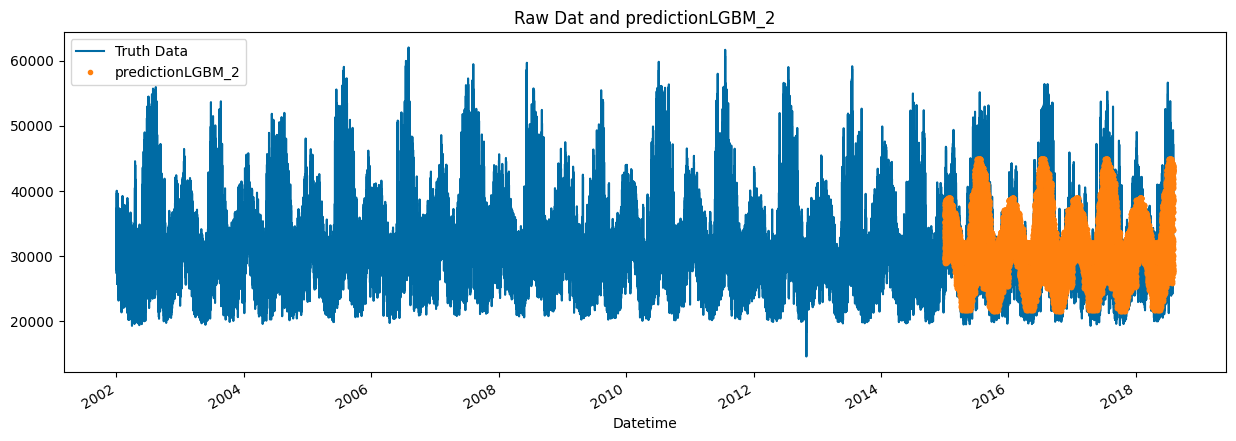

RMSE en conjunto de Test Modelo LGBM version 2: 3678.23


In [ ]:
test['predictionLGBM_2'] = reg_lightgbm_2.predict(X_test)
df = df.merge(test[['predictionLGBM_2']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['predictionLGBM_2'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'predictionLGBM_2'])
ax.set_title('Raw Dat and predictionLGBM_2')
plt.show()


score = np.sqrt(mean_squared_error(test['PJME_MW'], test['predictionLGBM_2']))
print(f'RMSE en conjunto de Test Modelo LGBM version 2: {score:0.2f}')

El modelo LGBM versión 2 con los parametros optimizados tiene un RMSE de 3678.23, mientras que el modelo LGBM original tiene un RMSE de 3793.18 en el conjunto de prueba.

Dado que el RMSE (Root Mean Squared Error) mide el promedio de los errores al cuadrado y es una métrica en la misma escala que las variables que estás prediciendo, un valor más bajo indica un mejor rendimiento del modelo.

En este caso, el modelo LGBM versión 2 tiene un RMSE más bajo, lo que significa que tiene un mejor rendimiento en el conjunto de prueba en comparación con el modelo LGBM original.

Tambien probamos con "Cross Validation"

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)  # predecir 1 año  , gap entre entrenamiento y validacion de 24 horas
df_copy = df.copy()
df_copy = df_copy.sort_index()

In [ ]:
tss

TimeSeriesSplit(gap=24, max_train_size=None, n_splits=5, test_size=8760)

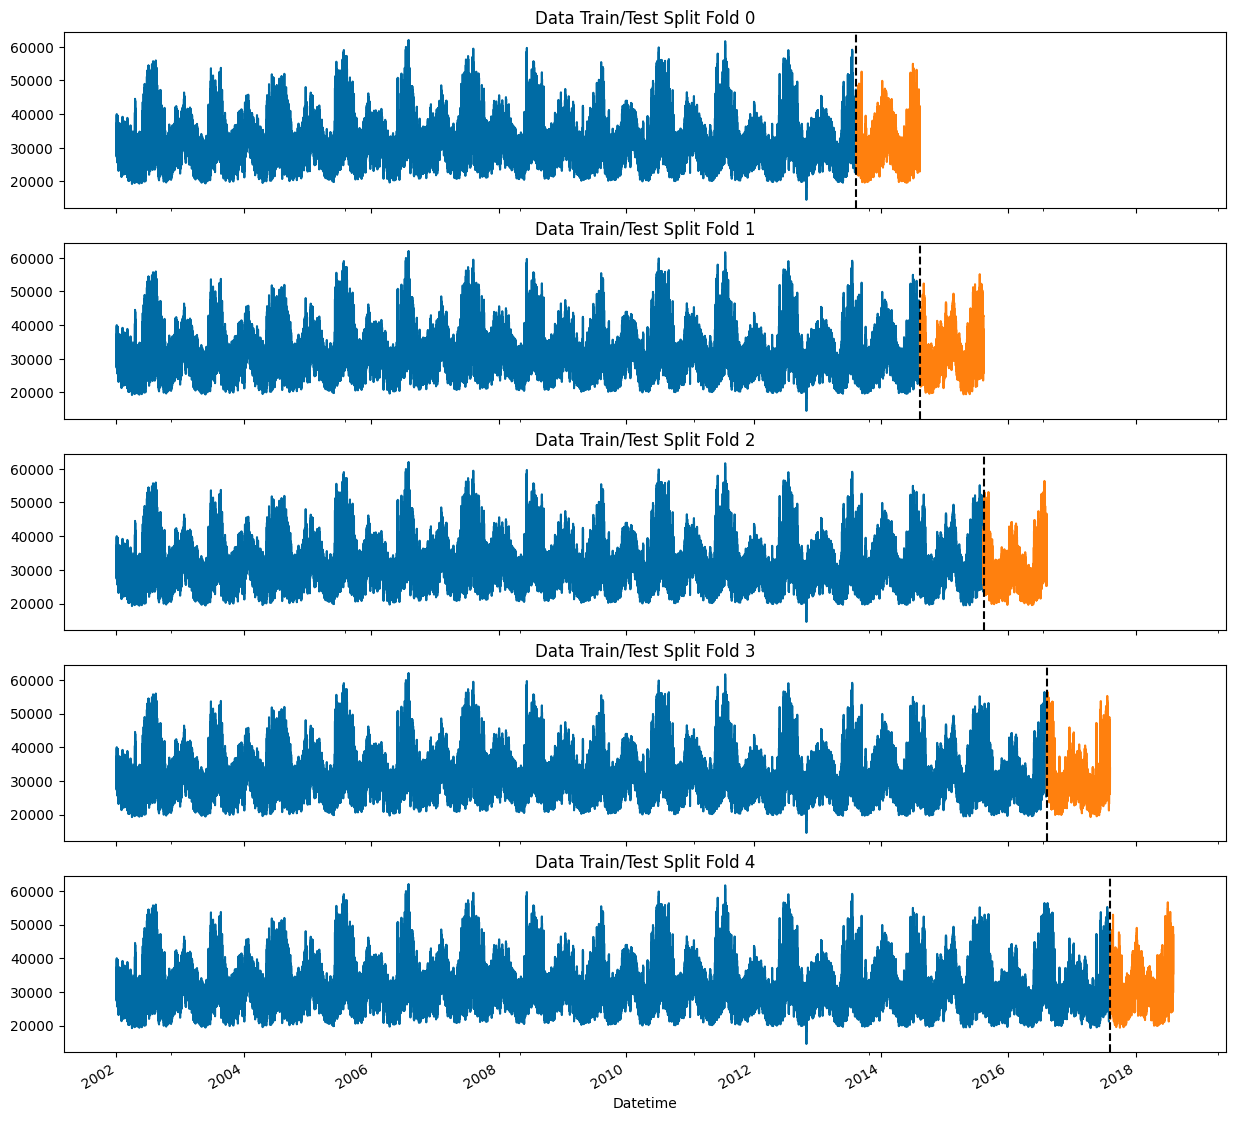

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df_copy):
    train = df_copy.iloc[train_idx]
    test = df_copy.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

Agregar Lags como Features

In [ ]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [ ]:
df = add_lags(df)

Train Using Cross Validation¶


In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32731.76588	validation_1-rmse:31968.42649


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:55:10] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12534.70818	validation_1-rmse:11932.01722
[200]	validation_0-rmse:5748.57698	validation_1-rmse:5351.55739
[300]	validation_0-rmse:3877.11486	validation_1-rmse:3834.19409
[400]	validation_0-rmse:3445.50303	validation_1-rmse:3668.39784
[486]	validation_0-rmse:3335.96127	validation_1-rmse:3666.32985
[0]	validation_0-rmse:32671.60197	validation_1-rmse:32161.81173


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:55:23] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12513.85546	validation_1-rmse:12253.06023
[200]	validation_0-rmse:5756.76256	validation_1-rmse:5679.96764
[300]	validation_0-rmse:3907.79689	validation_1-rmse:3940.21307
[400]	validation_0-rmse:3480.11287	validation_1-rmse:3597.70833
[500]	validation_0-rmse:3355.89372	validation_1-rmse:3519.31784
[600]	validation_0-rmse:3300.46863	validation_1-rmse:3486.96677
[700]	validation_0-rmse:3260.29443	validation_1-rmse:3467.29943
[800]	validation_0-rmse:3222.26281	validation_1-rmse:3449.10575
[900]	validation_0-rmse:3193.83512	validation_1-rmse:3442.66729
[999]	validation_0-rmse:3168.03793	validation_1-rmse:3437.27708
[0]	validation_0-rmse:32634.52151	validation_1-rmse:30995.91864


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:55:34] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12500.56534	validation_1-rmse:11119.18219
[200]	validation_0-rmse:5752.00122	validation_1-rmse:4821.99828
[300]	validation_0-rmse:3917.31896	validation_1-rmse:3558.08671
[400]	validation_0-rmse:3497.66440	validation_1-rmse:3487.64747
[413]	validation_0-rmse:3474.66271	validation_1-rmse:3496.44925
[0]	validation_0-rmse:32526.04785	validation_1-rmse:31387.76529


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:55:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12461.51789	validation_1-rmse:11977.72388
[200]	validation_0-rmse:5737.53607	validation_1-rmse:5775.23673
[300]	validation_0-rmse:3915.45168	validation_1-rmse:4377.66630
[400]	validation_0-rmse:3498.74841	validation_1-rmse:4170.18367
[500]	validation_0-rmse:3381.37254	validation_1-rmse:4115.07616
[600]	validation_0-rmse:3322.98079	validation_1-rmse:4101.18107
[700]	validation_0-rmse:3280.08643	validation_1-rmse:4082.99495
[800]	validation_0-rmse:3249.25650	validation_1-rmse:4073.37628
[871]	validation_0-rmse:3229.67829	validation_1-rmse:4074.40104
[0]	validation_0-rmse:32454.30477	validation_1-rmse:31363.73374


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:55:52] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12442.89917	validation_1-rmse:11905.74914
[200]	validation_0-rmse:5751.46609	validation_1-rmse:5575.22161
[300]	validation_0-rmse:3949.69180	validation_1-rmse:4135.20729
[400]	validation_0-rmse:3541.33416	validation_1-rmse:3994.91458
[432]	validation_0-rmse:3491.68673	validation_1-rmse:3994.64833


In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3727.8978
Fold scores:[3663.8392090127727, 3437.277075792468, 3474.4113341180796, 4073.22469462666, 3990.7365678240853]


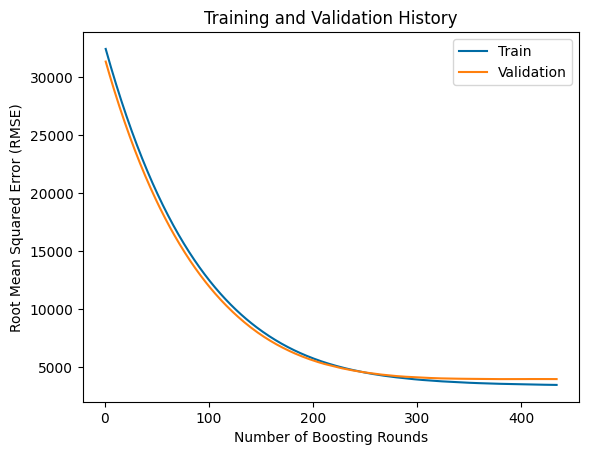

In [ ]:
# Plot the training and validation history
results = reg.evals_result()
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Training and Validation History')
plt.legend()
plt.show()

4. Predecir el futuro Reentrenamiento en todos los datos
Para predecir el futuro necesitamos un marco de datos vacío para rangos de fechas futuros.
Ejecute esas fechas a través de nuestro código de creación de funciones + creación de retrasos

In [ ]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32390.63673


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:57:49] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12422.10764
[200]	validation_0-rmse:5751.61724
[300]	validation_0-rmse:3969.98772
[400]	validation_0-rmse:3569.27828
[499]	validation_0-rmse:3455.65851


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [ ]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [ ]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [ ]:
future_w_features = df_and_future.query('isFuture').copy()


In [ ]:
future_w_features.head()

PJME_MW  hour  dayofweek  quarter  month  year  \
2018-08-03 00:00:00      NaN     0          4        3      8  2018   
2018-08-03 01:00:00      NaN     1          4        3      8  2018   
2018-08-03 02:00:00      NaN     2          4        3      8  2018   
2018-08-03 03:00:00      NaN     3          4        3      8  2018   
2018-08-03 04:00:00      NaN     4          4        3      8  2018   

                     dayofyear  dayofmonth  weekofyear  prediction_XGB_x  \
2018-08-03 00:00:00        215           3          31               NaN   
2018-08-03 01:00:00        215           3          31               NaN   
2018-08-03 02:00:00        215           3          31               NaN   
2018-08-03 03:00:00        215           3          31               NaN   
2018-08-03 04:00:00        215           3          31               NaN   

                     prediction_XGB_y  predictionLGBM_x  predictionLGBM_y  \
2018-08-03 00:00:00               NaN               NaN               NaN   
2018-08-03 01:00:00               NaN               NaN               NaN   
2018-08-03 02:00:00               NaN               NaN               NaN   
2018-08-03 03:00:00               NaN               NaN               NaN   
2018-08-03 04:00:00               NaN               NaN               NaN   

                     predictionLGBM_2     lag1     lag2     lag3  isFuture  
2018-08-03 00:00:00               NaN  33539.0  32094.0  31695.0      True  
2018-08-03 01:00:00               NaN  30781.0  29503.0  29128.0      True  
2018-08-03 02:00:00               NaN  29015.0  27712.0  27373.0      True  
2018-08-03 03:00:00               NaN  27884.0  26535.0  26233.0      True  
2018-08-03 04:00:00               NaN  27223.0  25870.0  25643.0      True

Predict the future¶


In [ ]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])


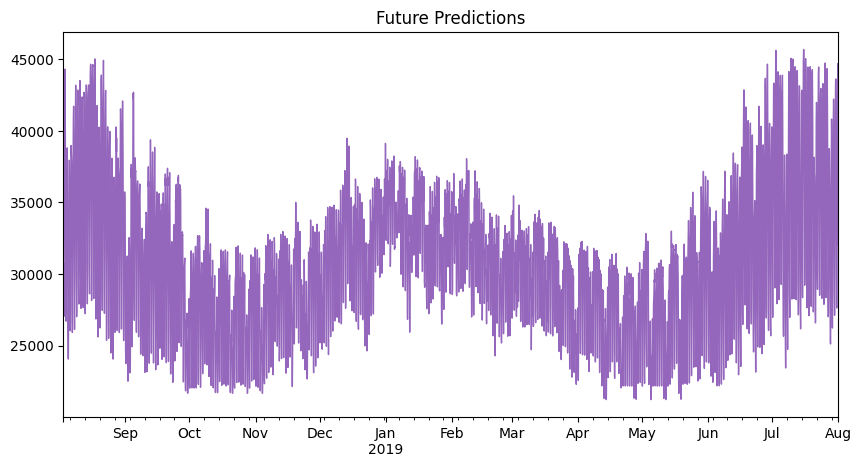

In [ ]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

SAving Model for later

In [ ]:
# Save model
reg.save_model('model.json')

<Axes: title={'center': 'Future Predictions'}>

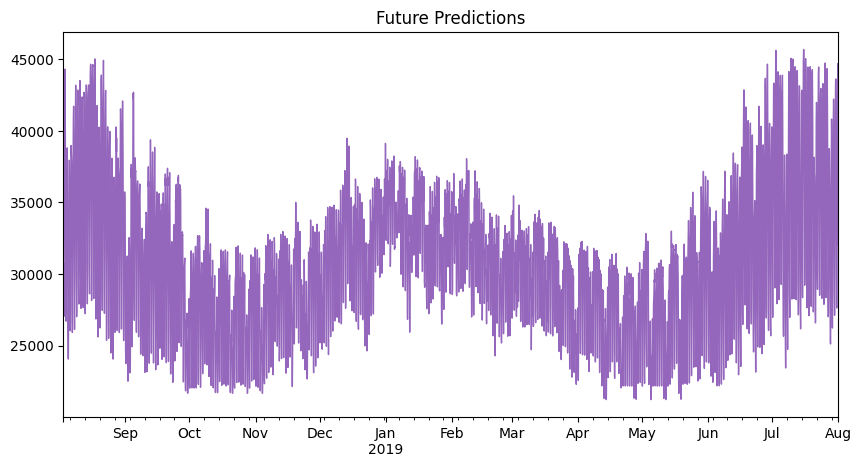

In [ ]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')

FIN DEL EJERCICIO SINCRONICO

Aclaracion : Este ejercicio es el punto de partida para la tarea practica asincronica de la clase de hoy